# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Virginie Piskin"
student2 = "Valentin Borgeaud"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [1]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


### Plotting

In [2]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [3]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

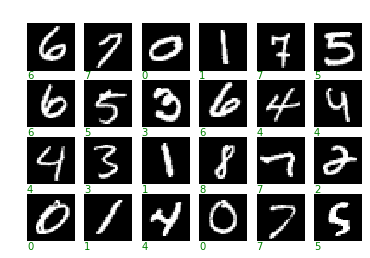

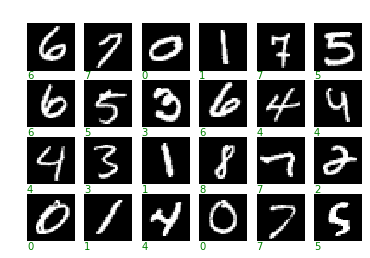

In [4]:
plot_some_samples(x_train, y_train)

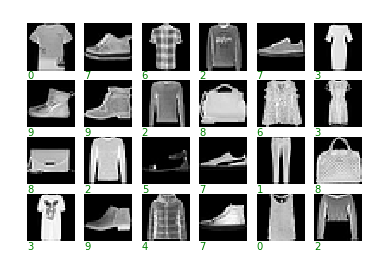

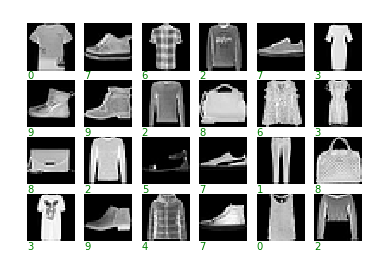

In [5]:
plot_some_samples(x_fashion_train, y_fashion_train)

### Answer to Q2:
The green digits at the bottom left of each image indicate the true label of each image.
For the mnist dataset the labels correspond to the true number we should read on the images.
For the fashion-mnist dataset the labels correspond to a class id assigned to the image depending on the clothing item. 

For the fashion MNIST dataset, the numbers correspond to the following labels:
* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [6]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [7]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

#### Note: for the whole project, we are not asked anywhere to use the test data. Therefore, we decided to use the test set as the validation set to increase the number of training sample. We know that in real scenario cases the test set should be left unoutched and part of the training data should be splitted to be used as the validation set (we should even perform cross validation if possible).

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [8]:
'''
    Function that creates a multi-layered neural network for multi-class softmax classification.
    
    Inputs:
        n_hidden_layer [int]: 
                    Number of hidden layers to be created.        
        optimizer [string]:
                    Optimization method to be used throughout the network (see methods available in Keras).
        units [int]: 
                    Number of neurons per hidden layer.
        features [int]:
                    Number of neurons on the input layer = length of one input vector.
        n_categories [int]:
                    Number of output categories.
    
    Outputs:
        model [Keras Sequential]:
                    Created Neural Network model according to the specified arguments.
                    Ready to be used to fit the data.
'''
def build_multi_layer_model(n_hidden_layer, optimizer, units = 32, features = 784, n_categories = 10):
    
    # True if the number of hidden layers is not nul
    hidden = n_hidden_layer > 0
    
    # Initialization of the Neural Network model
    model = Sequential()
    
    # If hidden layers are requested we will add them iteratively
    if (hidden == True):
        
        # We add the first hidden layer for which we need to specify the input shape
        model.add(Dense(units, activation='relu', input_shape=(features,)))
    
        # We add the remaining n_hidden_layer-1 layers
        for n in range(n_hidden_layer - 1):
            model.add(Dense(units, activation='relu'))
    
    # We add the output layer (if single layer we use the number of features as input shape otherwise the number of units)
    model.add(Dense(n_categories, activation='softmax', input_shape=(units,) if hidden else (features,)))
    
    # We specify the optimization method, the loss function and the performance metric
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

##### We use the early stopping callback defined in keras to stop the training if the change in the validation loss becomes small enough. We use this early stopping callback in all the following exercises

In [0]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=12, verbose=1,restore_best_weights=True)

In [0]:
# Create a model with 0 hidden layers using the stochastic gradient descend
model = build_multi_layer_model(n_hidden_layer=0, units=32, optimizer='sgd')

# Fit the data with the created model
history = model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[early_stopping_callback])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 2s 31us/step - loss: 1.2749 - acc: 0.7014 - val_loss: 0.8112 - val_acc: 0.8316
Epoch 2/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.7124 - acc: 0.8425 - val_loss: 0.6076 - val_acc: 0.8613
Epoch 3/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.5841 - acc: 0.8601 - val_loss: 0.5260 - val_acc: 0.8723
Epoch 4/500
60000/60000 [==============================] - 2s 32us/step - loss: 0.5228 - acc: 0.8698 - val_loss: 0.4802 - val_acc: 0.8787
Epoch 5/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.4855 - acc: 0.8765 - val_loss: 0.4502 - val_acc: 0.8837
Epoch 6/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.4598 - acc: 0.8808 - val_loss: 0.4291 - val_acc: 0.8875
Ep

##### We see that the training stop after 375 epoch thanks to the early stopping callback. We can consider that there is no further improvement after this number of epoch.

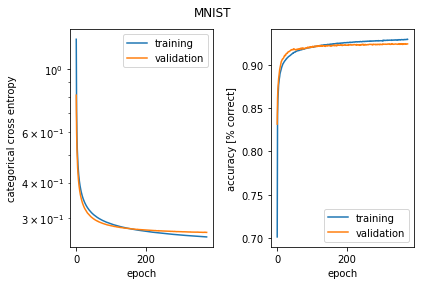

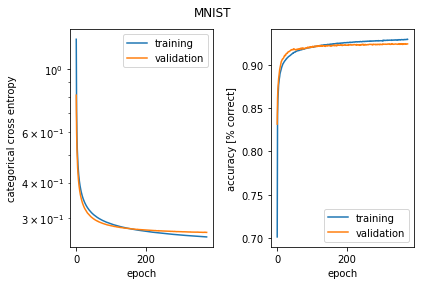

In [0]:
# Plot the training and validation error
plot_history(title='MNIST', history=history)

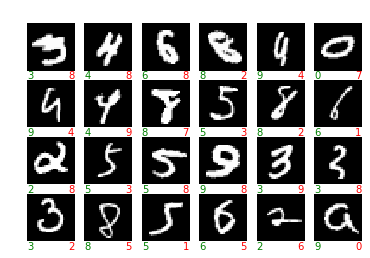

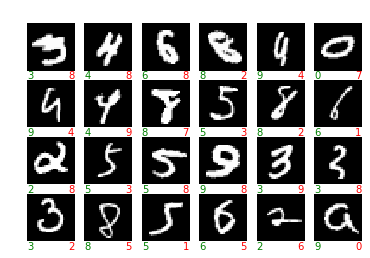

In [0]:
# Use the model to make predictions on the test set
y_hat_test = model.predict_classes(x_test)

# Number of different categories
y_classes = y_test.argmax(axis=1)

# Indices of images for which the network failed
error_indices = np.argwhere(y_hat_test != y_classes).flatten()

# Plot the images for which the network failed
plot_some_samples(x_test, y_classes, yhat=y_hat_test, select_from=error_indices)

In [0]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=12, verbose=1,restore_best_weights=True)

In [0]:
# Create a model with 0 hidden layers using the stochastic gradient descend
fashion_model = build_multi_layer_model(n_hidden_layer=0, units=32, optimizer='sgd')

# Fit the data with the created model
fashion_history = fashion_model.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=500, 
                                    verbose=1, validation_data=(x_fashion_test, y_fashion_test), callbacks=[early_stopping_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 24us/step - loss: 1.1482 - acc: 0.6626 - val_loss: 0.8645 - val_acc: 0.7245
Epoch 2/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.7789 - acc: 0.7539 - val_loss: 0.7419 - val_acc: 0.7555
Epoch 3/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.6945 - acc: 0.7785 - val_loss: 0.6850 - val_acc: 0.7754
Epoch 4/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.6484 - acc: 0.7915 - val_loss: 0.6506 - val_acc: 0.7857
Epoch 5/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.6178 - acc: 0.8003 - val_loss: 0.6261 - val_acc: 0.7932
Epoch 6/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.5958 - acc: 0.8066 - val_loss: 0.6082 - val_acc: 0.7956
Epoch 7/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.5785 - acc: 0.8103 - val_loss: 0.5929 - 

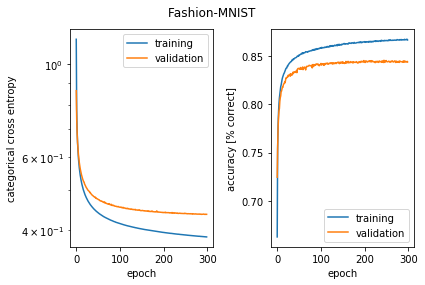

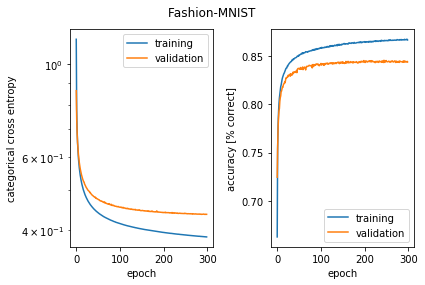

In [0]:
# Plot the training and validation error
plot_history(title='Fashion-MNIST', history=fashion_history)

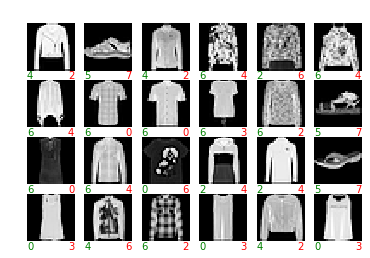

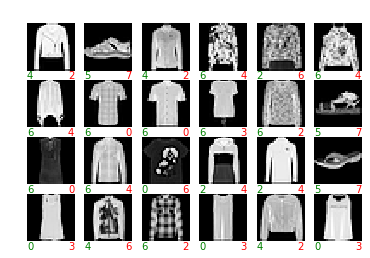

In [0]:
# Use the model to make predictions on the test set
y_hat_fashion_test = fashion_model.predict_classes(x_fashion_test)

# Number of different categories
y_fashion_classes = y_fashion_test.argmax(axis=1)

# Indices of images for which the network failed
fashion_error_indices = np.argwhere(y_hat_fashion_test != y_fashion_classes).flatten()

# Plot the images for which the network failed
plot_some_samples(x_fashion_test, y_fashion_classes, yhat=y_hat_fashion_test, select_from=fashion_error_indices)

### Answer to Q8:
The green digits are the true labels of the images and the red digits are the labels predicted by the model.

The accuracy for the MNIST dataset is around 0.924 whereas for the Fashion-MNIST dataset the accuracy is around 0.845. This result makes sense as it is harder to discriminate between clothing items than between numbers because of the high similarity of some clothing items.

* For the MNIST datasets the mistakes are due to the various types of handwritting. Even humans can have hard times to classify numbers badly written.
* For the Fashion-MNIST the mistakes are due to the very similar types of clothing items (for instance a shirt and a dress).

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

#### Model summary

In [66]:
model = build_multi_layer_model(n_hidden_layer=1, units=128, optimizer='sgd')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_381 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_382 (Dense)            (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [67]:
learning_rates = np.linspace(0.01, 0.1, 10)
models = []
histories = []
for lr in learning_rates:
    model = build_multi_layer_model(n_hidden_layer=1, units=128, optimizer=SGD(lr=lr))
    history = model.fit(x_train, y_train, 
                        batch_size=128, 
                        epochs=50, 
                        verbose=1, 
                        validation_data=(x_test, y_test))
    models.append(model)
    histories.append(history)
    

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 17s 276us/step - loss: 1.1971 - acc: 0.7128 - val_loss: 0.6465 - val_acc: 0.8518
Epoch 2/50
60000/60000 [==============================] - 6s 93us/step - loss: 0.5501 - acc: 0.8647 - val_loss: 0.4553 - val_acc: 0.8837
Epoch 3/50
60000/60000 [==============================] - 6s 102us/step - loss: 0.4361 - acc: 0.8846 - val_loss: 0.3879 - val_acc: 0.8971
Epoch 4/50
60000/60000 [==============================] - 7s 110us/step - loss: 0.3866 - acc: 0.8950 - val_loss: 0.3537 - val_acc: 0.9033
Epoch 5/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.3572 - acc: 0.9017 - val_loss: 0.3301 - val_acc: 0.9088
Epoch 6/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.3367 - acc: 0.9070 - val_loss: 0.3143 - val_acc: 0.9113
Epoch 7/50
60000/60000 [==============================] - 6s 108us/step - loss: 0.3208 - acc: 0.9109 - val_loss: 0.3009 - v

Epoch 10/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.2285 - acc: 0.9362 - val_loss: 0.2190 - val_acc: 0.9385
Epoch 11/50
60000/60000 [==============================] - 6s 92us/step - loss: 0.2196 - acc: 0.9388 - val_loss: 0.2114 - val_acc: 0.9395
Epoch 12/50
60000/60000 [==============================] - 4s 73us/step - loss: 0.2115 - acc: 0.9414 - val_loss: 0.2038 - val_acc: 0.9415
Epoch 13/50
60000/60000 [==============================] - 5s 91us/step - loss: 0.2041 - acc: 0.9434 - val_loss: 0.1983 - val_acc: 0.9439
Epoch 14/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.1971 - acc: 0.9453 - val_loss: 0.1923 - val_acc: 0.9448
Epoch 15/50
60000/60000 [==============================] - 4s 69us/step - loss: 0.1907 - acc: 0.9468 - val_loss: 0.1860 - val_acc: 0.9467
Epoch 16/50
60000/60000 [==============================] - 4s 64us/step - loss: 0.1847 - acc: 0.9484 - val_loss: 0.1814 - val_acc: 0.9474
Epoch 17/50
60000/60000 [=========

60000/60000 [==============================] - 6s 94us/step - loss: 0.1326 - acc: 0.9631 - val_loss: 0.1368 - val_acc: 0.9602
Epoch 20/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.1282 - acc: 0.9647 - val_loss: 0.1347 - val_acc: 0.9607
Epoch 21/50
60000/60000 [==============================] - 6s 102us/step - loss: 0.1243 - acc: 0.9658 - val_loss: 0.1304 - val_acc: 0.9631
Epoch 22/50
60000/60000 [==============================] - 6s 105us/step - loss: 0.1202 - acc: 0.9665 - val_loss: 0.1272 - val_acc: 0.9631
Epoch 23/50
60000/60000 [==============================] - 6s 107us/step - loss: 0.1167 - acc: 0.9680 - val_loss: 0.1250 - val_acc: 0.9649
Epoch 24/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.1134 - acc: 0.9691 - val_loss: 0.1225 - val_acc: 0.9653
Epoch 25/50
60000/60000 [==============================] - 6s 101us/step - loss: 0.1103 - acc: 0.9696 - val_loss: 0.1216 - val_acc: 0.9667
Epoch 26/50
60000/60000 [================

60000/60000 [==============================] - 4s 63us/step - loss: 0.0526 - acc: 0.9862 - val_loss: 0.0806 - val_acc: 0.9757
Epoch 38/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.0511 - acc: 0.9868 - val_loss: 0.0813 - val_acc: 0.9752
Epoch 39/50
60000/60000 [==============================] - 4s 66us/step - loss: 0.0498 - acc: 0.9870 - val_loss: 0.0796 - val_acc: 0.9753
Epoch 40/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.0488 - acc: 0.9872 - val_loss: 0.0779 - val_acc: 0.9766
Epoch 41/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.0474 - acc: 0.9876 - val_loss: 0.0789 - val_acc: 0.9758
Epoch 42/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.0462 - acc: 0.9884 - val_loss: 0.0771 - val_acc: 0.9767
Epoch 43/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.0452 - acc: 0.9883 - val_loss: 0.0770 - val_acc: 0.9767
Epoch 44/50
60000/60000 [=====================

60000/60000 [==============================] - 5s 77us/step - loss: 0.0348 - acc: 0.9919 - val_loss: 0.0695 - val_acc: 0.9791
Epoch 47/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.0338 - acc: 0.9924 - val_loss: 0.0704 - val_acc: 0.9798
Epoch 48/50
60000/60000 [==============================] - 4s 75us/step - loss: 0.0330 - acc: 0.9927 - val_loss: 0.0688 - val_acc: 0.9799
Epoch 49/50
60000/60000 [==============================] - 5s 76us/step - loss: 0.0322 - acc: 0.9930 - val_loss: 0.0684 - val_acc: 0.9799
Epoch 50/50
60000/60000 [==============================] - 7s 117us/step - loss: 0.0313 - acc: 0.9933 - val_loss: 0.0713 - val_acc: 0.9789
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 21s 350us/step - loss: 0.5127 - acc: 0.8646 - val_loss: 0.3053 - val_acc: 0.9130
Epoch 2/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.2877 - acc: 0.9185 - val_loss: 0.2498 - val_acc: 0.

60000/60000 [==============================] - 4s 68us/step - loss: 0.0830 - acc: 0.9771 - val_loss: 0.0969 - val_acc: 0.9707
Epoch 14/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.0780 - acc: 0.9783 - val_loss: 0.0935 - val_acc: 0.9729
Epoch 15/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.0734 - acc: 0.9799 - val_loss: 0.0893 - val_acc: 0.9741
Epoch 16/50
60000/60000 [==============================] - 5s 88us/step - loss: 0.0694 - acc: 0.9809 - val_loss: 0.0880 - val_acc: 0.9738
Epoch 17/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0658 - acc: 0.9824 - val_loss: 0.0842 - val_acc: 0.9745
Epoch 18/50
60000/60000 [==============================] - 5s 76us/step - loss: 0.0627 - acc: 0.9830 - val_loss: 0.0852 - val_acc: 0.9741
Epoch 19/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.0594 - acc: 0.9839 - val_loss: 0.0809 - val_acc: 0.9744
Epoch 20/50
60000/60000 [=====================

60000/60000 [==============================] - 4s 69us/step - loss: 0.0454 - acc: 0.9882 - val_loss: 0.0762 - val_acc: 0.9759
Epoch 23/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.0434 - acc: 0.9891 - val_loss: 0.0735 - val_acc: 0.9776
Epoch 24/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.0413 - acc: 0.9897 - val_loss: 0.0729 - val_acc: 0.9771
Epoch 25/50
60000/60000 [==============================] - 6s 106us/step - loss: 0.0395 - acc: 0.9900 - val_loss: 0.0729 - val_acc: 0.9767
Epoch 26/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.0377 - acc: 0.9909 - val_loss: 0.0723 - val_acc: 0.9776
Epoch 27/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.0361 - acc: 0.9912 - val_loss: 0.0732 - val_acc: 0.9764
Epoch 28/50
60000/60000 [==============================] - 4s 73us/step - loss: 0.0347 - acc: 0.9915 - val_loss: 0.0709 - val_acc: 0.9779
Epoch 29/50
60000/60000 [====================

In [68]:
# This will not necessarily gives us the best learning rate as we are using sgd, but it will discard the ones that are really bad
best_idx = np.argmin([history.history['val_loss'][-1] for history in histories])
best_lr = learning_rates[best_idx]
best_sgd_hist = histories[best_idx]
print(f"\"Best\" learning rate: {best_lr}")

"Best" learning rate: 0.07


In [69]:
adam_model = build_multi_layer_model(n_hidden_layer=1, units=128, optimizer=Adam())
adam_history = adam_model.fit(x_train, y_train, 
                        batch_size=128, 
                        epochs=50, 
                        verbose=1, 
                        validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 20s 326us/step - loss: 0.3549 - acc: 0.9029 - val_loss: 0.1914 - val_acc: 0.9460
Epoch 2/50
60000/60000 [==============================] - 7s 119us/step - loss: 0.1648 - acc: 0.9528 - val_loss: 0.1446 - val_acc: 0.9593
Epoch 3/50
60000/60000 [==============================] - 7s 109us/step - loss: 0.1191 - acc: 0.9659 - val_loss: 0.1135 - val_acc: 0.9652
Epoch 4/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.0938 - acc: 0.9727 - val_loss: 0.1008 - val_acc: 0.9701
Epoch 5/50
60000/60000 [==============================] - 7s 110us/step - loss: 0.0751 - acc: 0.9784 - val_loss: 0.0884 - val_acc: 0.9736
Epoch 6/50
60000/60000 [==============================] - 7s 119us/step - loss: 0.0631 - acc: 0.9813 - val_loss: 0.0842 - val_acc: 0.9728
Epoch 7/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.0513 - acc: 0.9857 - val_loss: 0.0811 - 

In [18]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

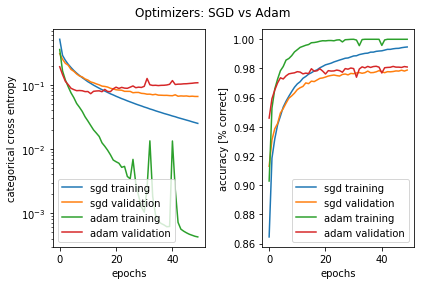

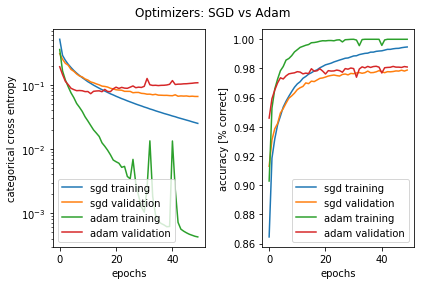

In [71]:
comparison_plot(best_sgd_hist, adam_history, 'sgd', 'adam', 'Optimizers: SGD vs Adam')

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) When the learning rate is too large, the model start to oscillate and can never converge to an optimal or suboptimal solution because changes are too large to learn anything.

B) When the learning rate is too small, the model takes a very long time to converge and can get stuck more easily in suboptimal solutions.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: From the graph, we can see that the ADAM optimizer starts to overfit around the epoch 12 where the validation loss starts to increase.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: The loss and accuracy curves are inversely correlated, i.e. when the loss is low, the accuracy is high and when the loss is high, the accuracy is low. However, when overfitting, the validation loss will generally starts to increase again while the accuracy remains the same or is reduced and the training loss will keep decreasing.

#### Adam on Fashion-MNIST

In [0]:
adam_fashion_model = build_multi_layer_model(n_hidden_layer=1, units=128, optimizer=Adam())
adam_fashion_history = adam_model.fit(x_fashion_train, y_fashion_train, 
                        batch_size=128, 
                        epochs=50, 
                        verbose=1, 
                        validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 54us/step - loss: 4.2337 - acc: 0.6452 - val_loss: 3.6245 - val_acc: 0.6793
Epoch 2/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.8075 - acc: 0.8090 - val_loss: 0.4967 - val_acc: 0.8369
Epoch 3/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.4255 - acc: 0.8534 - val_loss: 0.4486 - val_acc: 0.8499
Epoch 4/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.3811 - acc: 0.8662 - val_loss: 0.4253 - val_acc: 0.8578
Epoch 5/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.3565 - acc: 0.8734 - val_loss: 0.4103 - val_acc: 0.8602
Epoch 6/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.3347 - acc: 0.8793 - val_loss: 0.4008 - val_acc: 0.8631
Epoch 7/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.3212 - acc: 0.8831 - val_loss: 0.3970 - val_acc

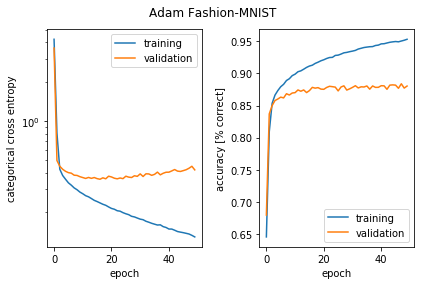

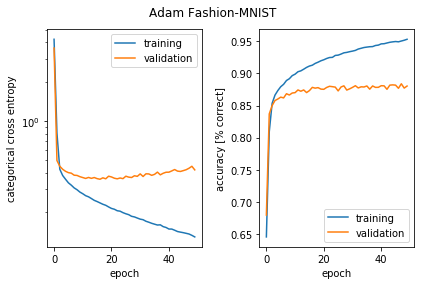

In [0]:
plot_history(title='Adam Fashion-MNIST', history=adam_fashion_history)

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [72]:
# Different layer sizes (number of neurons per layer) to be tested
layer_sizes = [10, 50, 100, 500, 700, 1000]

# Vectors to store models and histories from the various tests
models = []
histories = []

# Iterative fit of the models built with different layer sizes on the test set
for ls in layer_sizes:
    model = build_multi_layer_model(n_hidden_layer=1, units=ls, optimizer=Adam())
    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=18, verbose=1,restore_best_weights=True)
    history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1, 
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping_callback])
    models.append(model)
    histories.append(history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 17s 279us/step - loss: 0.7272 - acc: 0.8071 - val_loss: 0.3649 - val_acc: 0.9010
Epoch 2/50
60000/60000 [==============================] - 6s 93us/step - loss: 0.3360 - acc: 0.9061 - val_loss: 0.3010 - val_acc: 0.9163
Epoch 3/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.2932 - acc: 0.9170 - val_loss: 0.2796 - val_acc: 0.9221
Epoch 4/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.2730 - acc: 0.9222 - val_loss: 0.2686 - val_acc: 0.9262
Epoch 5/50
60000/60000 [==============================] - 7s 110us/step - loss: 0.2606 - acc: 0.9251 - val_loss: 0.2596 - val_acc: 0.9255
Epoch 6/50
60000/60000 [==============================] - 7s 111us/step - loss: 0.2516 - acc: 0.9289 - val_loss: 0.2535 - val_acc: 0.9310
Epoch 7/50
60000/60000 [==============================] - 7s 115us/step - loss: 0.2452 - acc: 0.9303 - val_loss: 0.2510 - va

60000/60000 [==============================] - 16s 259us/step - loss: 0.2642 - acc: 0.9261 - val_loss: 0.1316 - val_acc: 0.9623
Epoch 2/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.1064 - acc: 0.9693 - val_loss: 0.0881 - val_acc: 0.9737
Epoch 3/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.0707 - acc: 0.9795 - val_loss: 0.0752 - val_acc: 0.9762
Epoch 4/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.0499 - acc: 0.9850 - val_loss: 0.0731 - val_acc: 0.9762
Epoch 5/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.0360 - acc: 0.9898 - val_loss: 0.0635 - val_acc: 0.9812
Epoch 6/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.0271 - acc: 0.9922 - val_loss: 0.0603 - val_acc: 0.9804
Epoch 7/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.0199 - acc: 0.9946 - val_loss: 0.0595 - val_acc: 0.9810
Epoch 8/50
60000/60000 [==========================

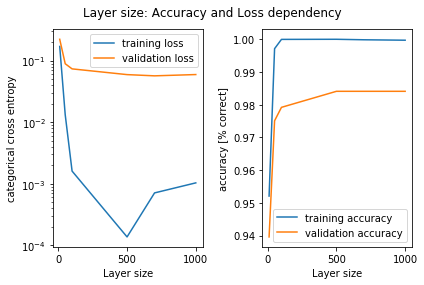

In [73]:
val_acc = [np.max(hist.history['val_acc']) for hist in histories]
train_acc = [np.max(hist.history['acc']) for hist in histories]

val_loss = [np.min(hist.history['val_loss']) for hist in histories]
train_loss = [np.min(hist.history['loss']) for hist in histories]

fig, ax1, ax2 = prepare_standardplot("Layer size: Accuracy and Loss dependency", "Layer size")    
ax1.plot(layer_sizes, train_loss, label='training loss')
ax1.plot(layer_sizes, val_loss, label='validation loss')
ax2.plot(layer_sizes, train_acc, label='training accuracy')
ax2.plot(layer_sizes, val_acc, label='validation accuracy')
finalize_standardplot(fig, ax1, ax2)

# See next plot for a more insight full result

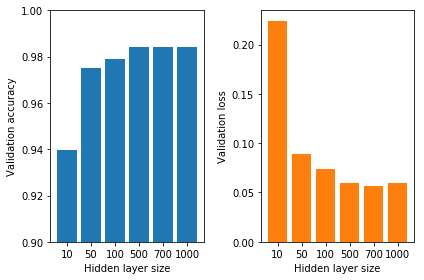

In [74]:
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


ax1.bar(np.array(range(len(layer_sizes))), np.array(val_acc), tick_label=layer_sizes, color='C0')
ax2.bar(np.array(range(len(layer_sizes))), np.array(val_loss), tick_label=layer_sizes,  color='C1')

ax1.set_ylim(0.9, 1)
ax1.set_xlabel('Hidden layer size')
ax2.set_xlabel('Hidden layer size')
ax1.set_ylabel('Validation accuracy')
ax2.set_ylabel('Validation loss')
plt.tight_layout()

plt.show()

In [75]:
best_idx = np.argmin(val_loss)
best_ls = layer_sizes[best_idx]
best_hist = histories[best_idx]
print(f"\"Best\" layer size: {best_ls}")
print(f"\"Best\" accuracy: " + str(val_acc[best_idx]))
print(f"\"Best\" loss: " + str(val_loss[best_idx])) 

"Best" layer size: 700
"Best" accuracy: 0.9841
"Best" loss: 0.05686630623647943


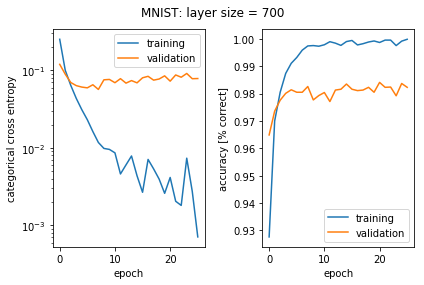

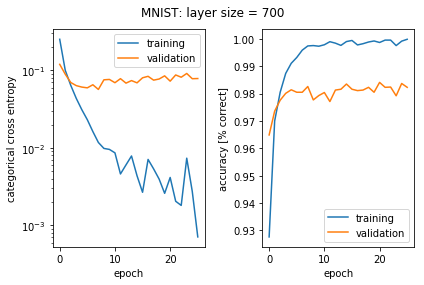

In [76]:
plot_history(title='MNIST: layer size = ' + str(best_ls), history=best_hist)

We observe that the model starts to overfit around the 7th epoch.

### Answer to Q2:
> General approximation theorem: "In the mathematical theory of artificial neural networks, the universal approximation theorem states that a feed-forward network with a single hidden layer containing a finite number of neurons can approximate continuous functions on compact subsets of Rn, under mild assumptions on the activation function. The theorem thus states that simple neural networks can represent a wide variety of interesting functions when given appropriate parameters; however, it does not touch upon the algorithmic learnability of those parameters." Quote from Wikipedia

The trend we observe is in accordance with the "General approximation theroem". What we observe is that by increasing the number of neuron in a hidden single layer, the accuracy on the training function becomes bigger and bigger and its entropy becomes smaller and smaller which means that the neural network almost perfectly estimate the training function with a high number of nodes in a single layer. However, by looking at the validation metrics, we still observe that the overall function is not perfectly estimated but we can still reach high accuracies.

#### Tests for the Fashion-MNIST dataset

In [77]:
# Different layer sizes (number of neurons per layer) to be tested
layer_sizes = [10, 50, 100, 500, 700, 1000]

# Vectors to store models and histories from the various tests
models = []
histories = []

# Iterative fit of the models built with different layer sizes on the test set
for ls in layer_sizes:
    model = build_multi_layer_model(n_hidden_layer=1, units=ls, optimizer=Adam())
    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=18, verbose=1,restore_best_weights=True)
    history = model.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=50, verbose=1, 
                        validation_data=(x_fashion_test, y_fashion_test), callbacks=[early_stopping_callback])
    models.append(model)
    histories.append(history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 18s 304us/step - loss: 0.8891 - acc: 0.6966 - val_loss: 0.6152 - val_acc: 0.7861
Epoch 2/50
60000/60000 [==============================] - 6s 93us/step - loss: 0.5226 - acc: 0.8237 - val_loss: 0.5155 - val_acc: 0.8227
Epoch 3/50
60000/60000 [==============================] - 7s 113us/step - loss: 0.4714 - acc: 0.8390 - val_loss: 0.4941 - val_acc: 0.8297
Epoch 4/50
60000/60000 [==============================] - 8s 134us/step - loss: 0.4457 - acc: 0.8463 - val_loss: 0.4776 - val_acc: 0.8309
Epoch 5/50
60000/60000 [==============================] - 7s 118us/step - loss: 0.4293 - acc: 0.8510 - val_loss: 0.4723 - val_acc: 0.8316
Epoch 6/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.4206 - acc: 0.8518 - val_loss: 0.4551 - val_acc: 0.8406
Epoch 7/50
60000/60000 [==============================] - 7s 110us/step - loss: 0.4093 - acc: 0.8566 - val_loss: 0.4477 - v

Epoch 9/50
60000/60000 [==============================] - 6s 92us/step - loss: 0.3112 - acc: 0.8875 - val_loss: 0.3688 - val_acc: 0.8662
Epoch 10/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.3031 - acc: 0.8903 - val_loss: 0.3589 - val_acc: 0.8722
Epoch 11/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.2970 - acc: 0.8924 - val_loss: 0.3504 - val_acc: 0.8733
Epoch 12/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.2883 - acc: 0.8954 - val_loss: 0.3615 - val_acc: 0.8691
Epoch 13/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.2827 - acc: 0.8969 - val_loss: 0.3671 - val_acc: 0.8703
Epoch 14/50
60000/60000 [==============================] - 7s 109us/step - loss: 0.2782 - acc: 0.8989 - val_loss: 0.3859 - val_acc: 0.8600
Epoch 15/50
60000/60000 [==============================] - 7s 110us/step - loss: 0.2712 - acc: 0.9003 - val_loss: 0.3524 - val_acc: 0.8739
Epoch 16/50
60000/60000 [=======

60000/60000 [==============================] - 5s 82us/step - loss: 0.2082 - acc: 0.9217 - val_loss: 0.3154 - val_acc: 0.8914
Epoch 13/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.1984 - acc: 0.9262 - val_loss: 0.3123 - val_acc: 0.8935
Epoch 14/50
60000/60000 [==============================] - 5s 77us/step - loss: 0.1904 - acc: 0.9293 - val_loss: 0.3222 - val_acc: 0.8900
Epoch 15/50
60000/60000 [==============================] - 5s 88us/step - loss: 0.1857 - acc: 0.9305 - val_loss: 0.3360 - val_acc: 0.8890
Epoch 16/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.1801 - acc: 0.9325 - val_loss: 0.3193 - val_acc: 0.8937
Epoch 17/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.1726 - acc: 0.9352 - val_loss: 0.3287 - val_acc: 0.8916
Epoch 18/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.1667 - acc: 0.9372 - val_loss: 0.3197 - val_acc: 0.8942
Epoch 19/50
60000/60000 [=====================

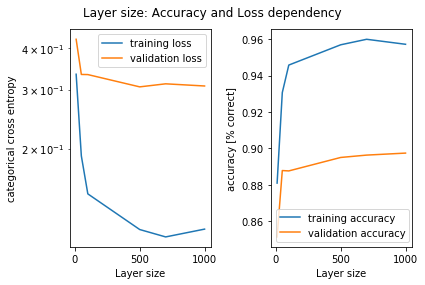

In [78]:
# Extract best accuracy and loss values from the history vectors
val_acc = [np.max(hist.history['val_acc']) for hist in histories]
train_acc = [np.max(hist.history['acc']) for hist in histories]

val_loss = [np.min(hist.history['val_loss']) for hist in histories]
train_loss = [np.min(hist.history['loss']) for hist in histories]

# Plot the accuracy and the loss according to the layer size
fig, ax1, ax2 = prepare_standardplot("Layer size: Accuracy and Loss dependency", "Layer size")    
ax1.plot(layer_sizes, train_loss, label='training loss')
ax1.plot(layer_sizes, val_loss, label='validation loss')
ax2.plot(layer_sizes, train_acc, label='training accuracy')
ax2.plot(layer_sizes, val_acc, label='validation accuracy')
finalize_standardplot(fig, ax1, ax2)

# See next plot for a more insightful result

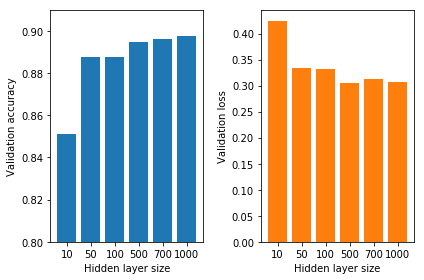

In [79]:
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


ax1.bar(np.array(range(len(layer_sizes))), np.array(val_acc), tick_label=layer_sizes, color='C0')
ax2.bar(np.array(range(len(layer_sizes))), np.array(val_loss), tick_label=layer_sizes,  color='C1')

ax1.set_ylim(0.8, 0.91)
ax1.set_xlabel('Hidden layer size')
ax2.set_xlabel('Hidden layer size')
ax1.set_ylabel('Validation accuracy')
ax2.set_ylabel('Validation loss')
plt.tight_layout()

plt.show()

In [80]:
best_idx = np.argmin(val_loss)
best_ls = layer_sizes[best_idx]
best_hist = histories[best_idx]
print(f"\"Best\" layer size: {best_ls}")
print(f"\"Best\" accuracy: " + str(val_acc[best_idx]))
print(f"\"Best\" loss: " + str(val_loss[best_idx])) 

"Best" layer size: 500
"Best" accuracy: 0.895
"Best" loss: 0.30581616048812865


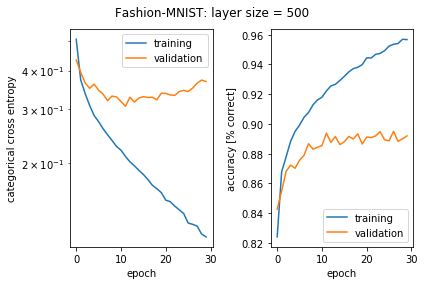

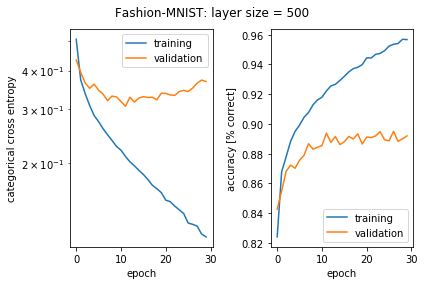

In [81]:
plot_history(title='Fashion-MNIST: layer size = ' + str(best_ls), history=best_hist)

### Answer to Q2 for Fashion-MNIST

We conclude the same thing as for the MNIST dataset. The General Approximation theorem holds for the same reasons already given above. However, the Fashion-MNIST dataset still has lower scores than the MNIST one, even with a very high number of neurons, probably because the fashion shapes are more similar to each others and it is therefore less easy do distinguish and classify the images.

We also observe that overfitting start around the 11th epoch.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [9]:
from keras import regularizers
from keras.layers import BatchNormalization

In [10]:
def build_regularized_multi_layer_model(n_hidden_layer, optimizer, kernel_reg, bias_reg, dropout, batch_normalization,
                                        units = 32, features = 784, n_categories = 10):

    """Function that creates a multi-layered neural network for multi-class softmax classification.
    
    Inputs:
        n_hidden_layer [int]     -- Number of hidden layers to be created.        
        optimizer [string]       -- Optimization method to be used throughout the network 
                                    (see methods available in Keras).
        kernel_reg []            -- Regularization method used on the weights. 
                                    Instance of keras.regularizers.Regularizer (see methods available in Keras)
        bias_reg []              -- Regularization method used on the biases.
                                    Instance of keras.regularizers.Regularizer (see methods available in Keras)
        dropout [double]         -- Probability with which the nodes are dropped-out
                                    The value must be in [0,1]
        batch_normalization [boolean] -- Add batch normalization before each layer
        units [int]              -- Number of neurons per hidden layer.
        features [int]           -- Number of neurons on the input layer = length of one input vector.
        n_categories [int]       -- Number of output categories.
    
    Outputs:
        model [Keras Sequential] -- Created Neural Network model according to the specified arguments.
                                    Ready to be used to fit the data.""" 
    
    # True if the number of hidden layers is not nul
    hidden = n_hidden_layer > 0
    
    # Initialization of the Neural Network model
    model = Sequential()
    
    # If hidden layers are requested we will add them iteratively
    if (hidden == True):
        
        if (batch_normalization):
            model.add(BatchNormalization())
        
        # We add the first hidden layer for which we need to specify the input shape
        model.add(Dense(units, activation='relu', input_shape=(features,), 
                        kernel_regularizer=kernel_reg, bias_regularizer=bias_reg))
    
        # We add the remaining n_hidden_layer-1 layers
        for n in range(n_hidden_layer - 1):
            if (batch_normalization):
                model.add(BatchNormalization())
            model.add(Dense(units, activation='relu', kernel_regularizer=kernel_reg, bias_regularizer=bias_reg))
    
    # We add the output layer (if single layer we use the number of features as input shape otherwise the number of units)
    model.add(Dense(n_categories, activation='softmax', input_shape=(units,) if hidden else (features,)))
    
    # We specify the optimization method, the loss function and the performance metric
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
def test_models(x_train, y_train, x_test, y_test, n_hidden_layers, dropout, reg_values, k_reg, b_reg, batch_normalization, epochs):
    val_loss = []
    val_acc = []
    histories = []
    for dp in dropout:
        for reg in reg_values:
            print(f"Dropout: {dp}, Regularizer: {reg}")
            model = build_regularized_multi_layer_model(n_hidden_layer=n_hidden_layers, units=50, optimizer=Adam(), kernel_reg=k_reg(reg),
                                                        bias_reg=b_reg(reg), dropout=dp, batch_normalization=batch_normalization)
            
            history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, verbose=0, 
                                validation_data=(x_test, y_test))
            score = [np.mean(history.history['val_loss'][-1]), np.mean(history.history['val_acc'][-1])] 
            val_loss.append(score[0])
            val_acc.append(score[1])
            histories.append(history)
            print("Validation Loss: ", score[0], " - Validation Accuracy: ", score[1])
            
    return histories[np.argmax(val_loss)]

##### To be able to test a bigger number of parameters and for training time reasons, we decided to run all our different models during 20 epochs only and only run the most promising one during 100 epochs. It is possible though that the chosen most promising one after 100 epochs would not be the best after 100 epochs if we ran all models for 100 epochs.

##### Also, to have more confidence in our results, it would be necessary to run multiple times the different models as their performance can vary between runs.

#### 1 Hidden Layer

In [38]:
best_hist_1_vanilla = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=1, dropout=[0], reg_values=[0], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=False, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3571204796075821  - Validation Accuracy:  0.8725


In [23]:
best_hist_1_vanilla_norm = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=1, dropout=[0], reg_values=[0], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=True, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3668085833549499  - Validation Accuracy:  0.8808


In [0]:
best_hist_1_l1 = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=1, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=False, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3467661714553833  - Validation Accuracy:  0.8765
Dropout: 0, Regularizer: 0.01
Validation Loss:  0.9338278667449951  - Validation Accuracy:  0.7757
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.6359285875797271  - Validation Accuracy:  0.8262
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.44484207537174225  - Validation Accuracy:  0.8683
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.3498099276542664  - Validation Accuracy:  0.8785
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  0.8947960144042969  - Validation Accuracy:  0.7889
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.6104360182285309  - Validation Accuracy:  0.8358
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.4527732036352158  - Validation Accuracy:  0.8692
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.348167277264595  - Validation Accuracy:  0.8765
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  0.8992128975868225  - Validation Accuracy:  0.7913
D

In [24]:
best_hist_1_l1_norm = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=1, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=True, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3907452798843384  - Validation Accuracy:  0.8777
Dropout: 0, Regularizer: 0.01
Validation Loss:  0.7053835073947906  - Validation Accuracy:  0.8246
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.5118373264312744  - Validation Accuracy:  0.8593
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.4294980039358139  - Validation Accuracy:  0.879
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.36827367680072787  - Validation Accuracy:  0.8791
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  0.7172240358829498  - Validation Accuracy:  0.8274
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.5199198815345765  - Validation Accuracy:  0.8552
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.43130307564735415  - Validation Accuracy:  0.8795
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.3668703014373779  - Validation Accuracy:  0.8816
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  0.6874531908988952  - Validation Accuracy:  0.825
D

In [0]:
best_hist_1_l2 = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=1, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l2, b_reg=regularizers.l2, batch_normalization=False, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.35234095442295077  - Validation Accuracy:  0.8757
Dropout: 0, Regularizer: 0.01
Validation Loss:  0.5082134099960327  - Validation Accuracy:  0.8498
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.42814819667339327  - Validation Accuracy:  0.8635
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.38045005316734315  - Validation Accuracy:  0.874
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.36433504960536955  - Validation Accuracy:  0.8719
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  0.4971382198810577  - Validation Accuracy:  0.8524
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.4142283800125122  - Validation Accuracy:  0.8735
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.37471103200912476  - Validation Accuracy:  0.8769
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.34335797300338744  - Validation Accuracy:  0.8775
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  0.5238082242012024  - Validation Accuracy:  0.8

In [0]:
best_hist_1_l2_norm = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=1, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l2, b_reg=regularizers.l2, batch_normalization=True, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3797754594802856  - Validation Accuracy:  0.8774
Dropout: 0, Regularizer: 0.01
Validation Loss:  0.46482868139743805  - Validation Accuracy:  0.8577
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.3981196820497513  - Validation Accuracy:  0.8792
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.3803058666944504  - Validation Accuracy:  0.8835
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.3648385880947113  - Validation Accuracy:  0.8824
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  0.44164847855567935  - Validation Accuracy:  0.8649
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.40152849187850953  - Validation Accuracy:  0.8779
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.39700744316577913  - Validation Accuracy:  0.8766
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.37264494547843935  - Validation Accuracy:  0.8822
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  0.4505086493730545  - Validation Accuracy:  0.8

#### 2 Hidden Layers

In [39]:
best_hist_2_vanilla = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=2, dropout=[0], reg_values=[0], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=False, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.34192985286712646  - Validation Accuracy:  0.8809


In [25]:
best_hist_2_vanilla_norm = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=2, dropout=[0], reg_values=[0], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=True, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.35505905873775484  - Validation Accuracy:  0.8862


In [0]:
best_hist_2_l1 = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=2, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=False, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3597704505443573  - Validation Accuracy:  0.8752
Dropout: 0, Regularizer: 0.01
Validation Loss:  0.9988689765930175  - Validation Accuracy:  0.7711
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.6030807384967803  - Validation Accuracy:  0.8406
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.4518289268016815  - Validation Accuracy:  0.872
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.3450935300588608  - Validation Accuracy:  0.8768
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  0.9424381912231445  - Validation Accuracy:  0.7928
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.6011333740711212  - Validation Accuracy:  0.8386
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.4651290905952454  - Validation Accuracy:  0.8651
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.3627175013065338  - Validation Accuracy:  0.875
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  0.9871298482894898  - Validation Accuracy:  0.7805
Dro

In [26]:
best_hist_2_l1_norm = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=2, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=True, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3604805921554565  - Validation Accuracy:  0.883
Dropout: 0, Regularizer: 0.01
Validation Loss:  0.7089757910728455  - Validation Accuracy:  0.8303
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.5299101499557495  - Validation Accuracy:  0.8593
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.45590835206508634  - Validation Accuracy:  0.8787
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.36078258347511294  - Validation Accuracy:  0.8813
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  0.7037082783699036  - Validation Accuracy:  0.833
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.5201513994216919  - Validation Accuracy:  0.8613
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.4417552686214447  - Validation Accuracy:  0.883
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.36662008850574496  - Validation Accuracy:  0.8825
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  0.7332648418426514  - Validation Accuracy:  0.828
Dr

In [0]:
best_hist_2_l2 = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=2, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l2, b_reg=regularizers.l2, batch_normalization=False, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3498713227748871  - Validation Accuracy:  0.8785
Dropout: 0, Regularizer: 0.01
Validation Loss:  0.5577405722618103  - Validation Accuracy:  0.84
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.42515569665431974  - Validation Accuracy:  0.8705
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.3705187910079956  - Validation Accuracy:  0.8796
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.34348978607654573  - Validation Accuracy:  0.8804
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  0.6378794842720031  - Validation Accuracy:  0.8068
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.5052199823856354  - Validation Accuracy:  0.8432
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.38503489499092103  - Validation Accuracy:  0.8738
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.3543174992084503  - Validation Accuracy:  0.8782
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  0.5800457983970642  - Validation Accuracy:  0.8282


In [0]:
best_hist_2_l2_norm = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=2, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l2, b_reg=regularizers.l2, batch_normalization=True, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3827589012145996  - Validation Accuracy:  0.8765
Dropout: 0, Regularizer: 0.01
Validation Loss:  0.4512491123199463  - Validation Accuracy:  0.8683
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.3995258463382721  - Validation Accuracy:  0.88
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.3779660952091217  - Validation Accuracy:  0.8828
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.36535664608478546  - Validation Accuracy:  0.8841
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  0.44884036378860476  - Validation Accuracy:  0.8663
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.4153827596902847  - Validation Accuracy:  0.876
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.38744043809175494  - Validation Accuracy:  0.8866
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.3716903786122799  - Validation Accuracy:  0.8812
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  0.4616008480548859  - Validation Accuracy:  0.8601
D

#### 3 hidden layer

In [27]:
best_hist_3_vanilla = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=3, dropout=[0], reg_values=[0], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=False, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.35848743941783906  - Validation Accuracy:  0.8763


In [28]:
best_hist_3_vanilla_norm = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=3, dropout=[0], reg_values=[0], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=True, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3712847950935364  - Validation Accuracy:  0.8777


In [29]:
best_hist_3_l1 = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=3, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=False, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.34474544810056684  - Validation Accuracy:  0.8811
Dropout: 0, Regularizer: 0.01
Validation Loss:  1.0589872252464294  - Validation Accuracy:  0.7382
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.6888806391716004  - Validation Accuracy:  0.8175
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.4640401155948639  - Validation Accuracy:  0.8732
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.34244271601438525  - Validation Accuracy:  0.8821
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  1.1230274560928344  - Validation Accuracy:  0.7572
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.6562768560886383  - Validation Accuracy:  0.8368
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.48361560764312744  - Validation Accuracy:  0.8618
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.3650209980010986  - Validation Accuracy:  0.8759
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  1.0337273370742799  - Validation Accuracy:  0.760

In [30]:
best_hist_3_l1_norm = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=3, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=True, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3704437278747559  - Validation Accuracy:  0.8817
Dropout: 0, Regularizer: 0.01
Validation Loss:  0.7524713859558105  - Validation Accuracy:  0.8239
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.5731332888126374  - Validation Accuracy:  0.8493
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.4584363327503204  - Validation Accuracy:  0.8818
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.35067364325523376  - Validation Accuracy:  0.8854
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  0.7628913964271545  - Validation Accuracy:  0.8143
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.5478318274021149  - Validation Accuracy:  0.8591
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.45763826332092283  - Validation Accuracy:  0.8826
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.3717062113761902  - Validation Accuracy:  0.8764
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  0.7445042999267578  - Validation Accuracy:  0.8251

In [31]:
best_hist_3_l2 = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=3, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l2, b_reg=regularizers.l2, batch_normalization=False, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3371664813518524  - Validation Accuracy:  0.8812
Dropout: 0, Regularizer: 0.01
Validation Loss:  0.7011763241291046  - Validation Accuracy:  0.8048
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.4379990708351135  - Validation Accuracy:  0.8748
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.39612396812438966  - Validation Accuracy:  0.8737
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.3473542820453644  - Validation Accuracy:  0.88
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  0.6052954574584961  - Validation Accuracy:  0.8413
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.44485070402622223  - Validation Accuracy:  0.8746
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.3824973232269287  - Validation Accuracy:  0.8799
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.35537930998802186  - Validation Accuracy:  0.8781
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  0.6132410420894623  - Validation Accuracy:  0.8438


In [32]:
best_hist_3_l2_norm = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=3, dropout=[0, 0.2, 0.5, 0.8], reg_values=[0, 0.01, 0.001, 0.0001], 
            k_reg=regularizers.l2, b_reg=regularizers.l2, batch_normalization=True, epochs=20)

Dropout: 0, Regularizer: 0
Validation Loss:  0.3537694068670273  - Validation Accuracy:  0.8851
Dropout: 0, Regularizer: 0.01
Validation Loss:  0.4771612395763397  - Validation Accuracy:  0.8564
Dropout: 0, Regularizer: 0.001
Validation Loss:  0.4025006739616394  - Validation Accuracy:  0.8847
Dropout: 0, Regularizer: 0.0001
Validation Loss:  0.38912809500694273  - Validation Accuracy:  0.8819
Dropout: 0.2, Regularizer: 0
Validation Loss:  0.36076981630325317  - Validation Accuracy:  0.8865
Dropout: 0.2, Regularizer: 0.01
Validation Loss:  0.45885438933372497  - Validation Accuracy:  0.8653
Dropout: 0.2, Regularizer: 0.001
Validation Loss:  0.4124335058450699  - Validation Accuracy:  0.878
Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.40313852355480195  - Validation Accuracy:  0.8821
Dropout: 0.5, Regularizer: 0
Validation Loss:  0.37195955543518067  - Validation Accuracy:  0.8791
Dropout: 0.5, Regularizer: 0.01
Validation Loss:  0.45628877964019776  - Validation Accuracy:  0.8

##### We choose the model having 2 layers, with dropout=0.2 and L2-regularizer=0.0001 with batch normalization as it is one of the best model performing (loss ~=0.38 and accuracy ~=0.8866) even though a lot of them can get to equivalent scores. We now run it for 100 epochs.

In [21]:
# 1 layer reference
ex5_one_layer_vanilla = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=1, dropout=[0], reg_values=[0], 
            k_reg=regularizers.l1, b_reg=regularizers.l1, batch_normalization=False, epochs=100)

Dropout: 0, Regularizer: 0
Validation Loss:  0.4584205955028534  - Validation Accuracy:  0.8771


In [17]:
# 2 layer reference
ex5_fashion_vanilla = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=2, dropout=[0], reg_values=[0], 
            k_reg=regularizers.l2, b_reg=regularizers.l2, batch_normalization=False, epochs=100)

Dropout: 0, Regularizer: 0
Validation Loss:  0.5565545660972595  - Validation Accuracy:  0.8775


In [14]:
# Assumed best
ex5_best_fashion_model = test_models(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, n_hidden_layers=2, dropout=[0.2], reg_values=[0.0001], 
            k_reg=regularizers.l2, b_reg=regularizers.l2, batch_normalization=True, epochs=100)

Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.5644000845789909  - Validation Accuracy:  0.8778


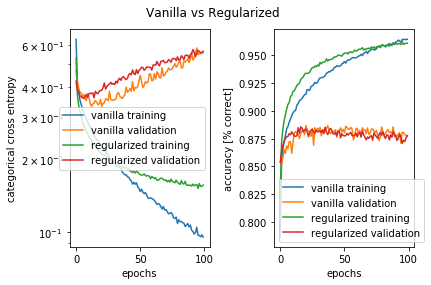

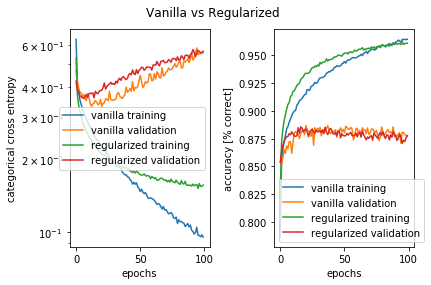

In [19]:
comparison_plot(ex5_fashion_vanilla, ex5_best_fashion_model, 'vanilla', 'regularized', 'Vanilla vs Regularized')

### Answer to question 2 (comments):

Oddly enough, both the non-regularized 2-layer (vanilla) models and regularized model achieves similar loss and accuracy scores even though it seems that the regularized model overfits faster than the vanilla version from the graphs and the 1-layer vanilla model achieves a lower loss for the same accuracy. A reason for not finding any differences could be that the model is just not complex enough for regularization to be useful or that the regularization is not strong enough or maybe we are just witnessing the problem of running models only once instead of averaging them over several runs.

In [22]:
# Best params run on MNIST
ex5_best_mnist_model = test_models(x_train, y_train, x_test, y_test, n_hidden_layers=2, dropout=[0.2], reg_values=[0.0001], 
            k_reg=regularizers.l2, b_reg=regularizers.l2, batch_normalization=True, epochs=100)

Dropout: 0.2, Regularizer: 0.0001
Validation Loss:  0.12699981678128242  - Validation Accuracy:  0.9774


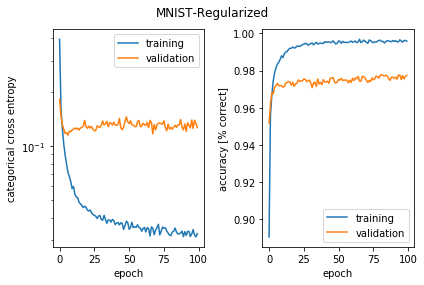

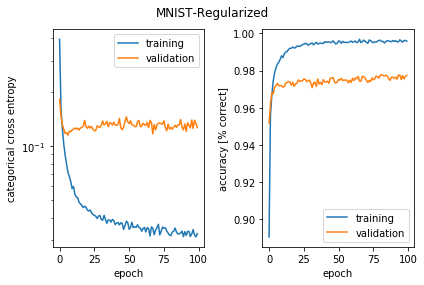

In [23]:
plot_history(title='MNIST-Regularized', history=ex5_best_mnist_model)

We also observe here for the MNIST dataset that we are very quickly overfitting with the regularization parameters chosen.

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [0]:
img_rows, img_cols = 28, 28

if keras.backend.image_data_format() == 'channels_first':
    x_train_conv = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test_conv = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    
    x_fashion_train_conv = x_fashion_train.reshape(x_fashion_train.shape[0], 1, img_rows, img_cols)
    x_fashion_test_conv = x_fashion_test.reshape(x_fashion_test.shape[0], 1, img_rows, img_cols)
else:
    x_train_conv = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test_conv = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    
    x_fashion_train_conv = x_fashion_train.reshape(x_fashion_train.shape[0], img_rows, img_cols, 1)
    x_fashion_test_conv = x_fashion_test.reshape(x_fashion_test.shape[0], img_rows, img_cols, 1)
    

In [0]:
def fitCNN(x_train, y_train, x_test, y_test, img_rows, img_cols, epochs, batch_size, activation='relu'):
    num_classes = 10
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation=activation,
                    input_shape=(img_rows, img_cols, 1)))
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                 optimizer=Adam(),
                 metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)
    return score, history

In [0]:
score, history = fitCNN(x_train_conv, y_train, x_test_conv, y_test, img_rows, img_cols, 12, 128)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 15s 250us/step - loss: 0.2424 - acc: 0.9268 - val_loss: 0.0600 - val_acc: 0.9804
Epoch 2/12
60000/60000 [==============================] - 12s 203us/step - loss: 0.0870 - acc: 0.9741 - val_loss: 0.0419 - val_acc: 0.9859
Epoch 3/12
60000/60000 [==============================] - 12s 207us/step - loss: 0.0640 - acc: 0.9808 - val_loss: 0.0334 - val_acc: 0.9891
Epoch 4/12
60000/60000 [==============================] - 12s 204us/step - loss: 0.0542 - acc: 0.9840 - val_loss: 0.0331 - val_acc: 0.9880
Epoch 5/12
60000/60000 [==============================] - 12s 208us/step - loss: 0.0462 - acc: 0.9863 - val_loss: 0.0301 - val_acc: 0.9895
Epoch 6/12
60000/60000 [==============================] - 12s 207us/step - loss: 0.0383 - acc: 0.9881 - val_loss: 0.0259 - val_acc: 0.9922
Epoch 7/12
60000/60000 [==============================] - 12s 208us/step - loss: 0.0339 - acc: 0.9894 - val_loss: 0.

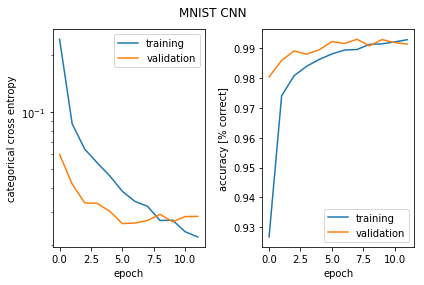

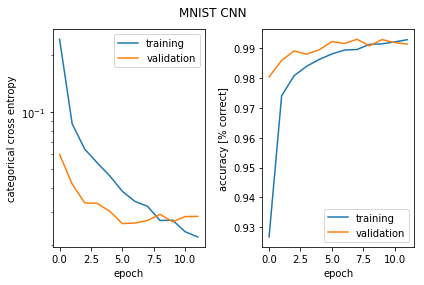

In [0]:
plot_history(title='MNIST CNN', history=history)

In [0]:
score, history = fitCNN(x_fashion_train_conv, y_fashion_train, x_fashion_test_conv, y_fashion_test, img_rows, img_cols, 20, 128)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 160s 3ms/step - loss: 0.5349 - acc: 0.8105 - val_loss: 0.3566 - val_acc: 0.8702
Epoch 2/20
60000/60000 [==============================] - 161s 3ms/step - loss: 0.3543 - acc: 0.8740 - val_loss: 0.2910 - val_acc: 0.8937
Epoch 3/20
60000/60000 [==============================] - 162s 3ms/step - loss: 0.3034 - acc: 0.8908 - val_loss: 0.2755 - val_acc: 0.9004
Epoch 4/20
60000/60000 [==============================] - 162s 3ms/step - loss: 0.2695 - acc: 0.9030 - val_loss: 0.2463 - val_acc: 0.9108
Epoch 5/20
60000/60000 [==============================] - 161s 3ms/step - loss: 0.2442 - acc: 0.9098 - val_loss: 0.2389 - val_acc: 0.9109
Epoch 6/20
60000/60000 [==============================] - 162s 3ms/step - loss: 0.2291 - acc: 0.9169 - val_loss: 0.2425 - val_acc: 0.9111
Epoch 7/20
60000/60000 [==============================] - 162s 3ms/step - loss: 0.2092 - acc: 0.9238 - val_loss: 0.2288 - 

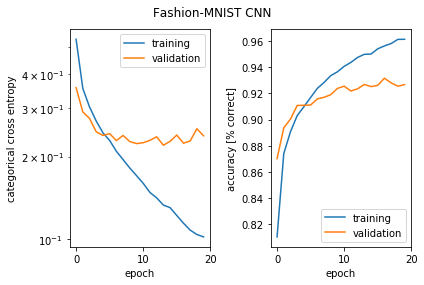

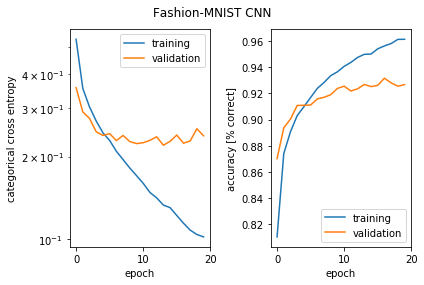

In [0]:
plot_history(title='Fashion-MNIST CNN', history=history)

### Answer to question 3:

The CNN models can get to better performances than the so far best performing (deep) neural network models while requiring fewer longer epochs (MNIST Deep: 0.9774 vs MNIST CNN: 0.9914 in accuarcy and Fashion-MNIST Deep:0.8778 vs Fashion-MNIST CNN: 0.9267 in accuracy). 

In term of accuarcy values, we see that the CNN model for the MNIST dataset performs slightly better than the deep NN but scores remains rather similar as the problem this problem is not that difficult and we see also that the CNN model accuracy for the Fashion-MNIST dataset is significantly better than the deep NN model as CNN are better for complex image classification (clothing items are more similar between each others than numbers and therefore harder to distinguish).

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [0]:
score, history = fitCNN(x_train_conv, y_train, x_test_conv, y_test, img_rows, img_cols, 30, 128, activation='sigmoid')

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 18s 299us/step - loss: 1.5150 - acc: 0.4803 - val_loss: 0.3109 - val_acc: 0.9147
Epoch 2/30
60000/60000 [==============================] - 15s 243us/step - loss: 0.3525 - acc: 0.9000 - val_loss: 0.2092 - val_acc: 0.9397
Epoch 3/30
60000/60000 [==============================] - 15s 242us/step - loss: 0.2737 - acc: 0.9208 - val_loss: 0.1678 - val_acc: 0.9502
Epoch 4/30
60000/60000 [==============================] - 15s 243us/step - loss: 0.2251 - acc: 0.9343 - val_loss: 0.1382 - val_acc: 0.9590
Epoch 5/30
60000/60000 [==============================] - 14s 241us/step - loss: 0.1882 - acc: 0.9452 - val_loss: 0.1062 - val_acc: 0.9683
Epoch 6/30
60000/60000 [==============================] - 14s 240us/step - loss: 0.1529 - acc: 0.9560 - val_loss: 0.0899 - val_acc: 0.9721
Epoch 7/30
60000/60000 [==============================] - 15s 242us/step - loss: 0.1258 - acc: 0.9637 - val_loss: 0.

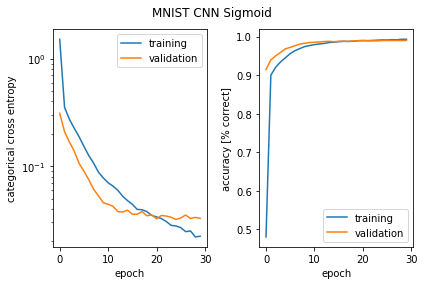

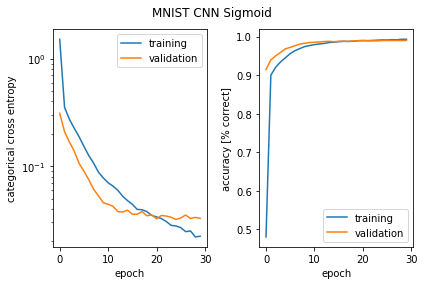

In [0]:
plot_history(title='MNIST CNN Sigmoid', history=history)

### Answer to question 1:

We observe that the networks is not able to learn more information at some point (compared to the ReLu network), or at least that he learns very slowly because of the vanishing gradient and that the score of this CNN does not reach the score of the CNN using ReLU even though both scores are very similar and it is therefore hard to know if the score difference is significant.

In [0]:
num_classes = 10
    
model = Sequential()
model.add(keras.layers.BatchNormalization(input_shape=(img_rows, img_cols, 1)))
model.add(Conv2D(32, kernel_size=(3, 3),
                activation='sigmoid',
                input_shape=(img_rows, img_cols, 1)))
model.add(keras.layers.BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='sigmoid'))
model.add(keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(keras.layers.BatchNormalization())
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

history = model.fit(x_train_conv, y_train,
                     batch_size=128,
                     epochs=30,
                     verbose=1,
                     validation_data=(x_test_conv, y_test))

score = model.evaluate(x_test_conv, y_test, verbose=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 23s 380us/step - loss: 0.2604 - acc: 0.9243 - val_loss: 0.3725 - val_acc: 0.8804
Epoch 2/30
60000/60000 [==============================] - 25s 418us/step - loss: 0.1076 - acc: 0.9690 - val_loss: 0.0610 - val_acc: 0.9802
Epoch 3/30
60000/60000 [==============================] - 22s 364us/step - loss: 0.0820 - acc: 0.9758 - val_loss: 0.0471 - val_acc: 0.9846
Epoch 4/30
60000/60000 [==============================] - 25s 409us/step - loss: 0.0711 - acc: 0.9790 - val_loss: 0.0486 - val_acc: 0.9849
Epoch 5/30
60000/60000 [==============================] - 22s 362us/step - loss: 0.0651 - acc: 0.9803 - val_loss: 0.0410 - val_acc: 0.9871
Epoch 6/30
60000/60000 [==============================] - 20s 340us/step - loss: 0.0608 - acc: 0.9808 - val_loss: 0.0432 - val_acc: 0.9872
Epoch 7/30
60000/60000 [==============================] - 19s 314us/step - loss: 0.0568 - acc: 0.9824 - val_loss: 0.

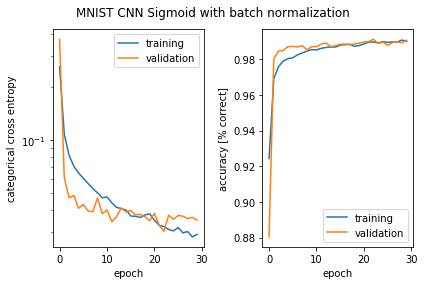

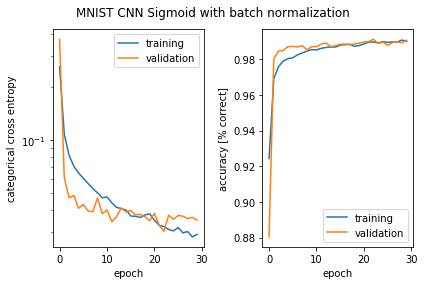

In [0]:
plot_history(title='MNIST CNN Sigmoid with batch normalization', history=history)

### Answer to question 2:

The performance very slightly increase and is close to the performance of the ReLu network but it is impossible to say if this increase is significant or not.

Note: Maybe it would have been easier to see differences by comparing trainings on the Fashion-MNIST dataset as the problem is more complex and it is know that batch normalization generally improves performance of CNNs.